In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [2]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [3]:
# Analysis; 'centrality' or 'max_flow'
analysis = 'max_flow'

In [4]:
node_removals_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/wfcr_node_removal_df.pkl')
if analysis == 'centrality':
    node_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_node_removal.pkl').head(100)

# NODE: Network Impact Heatmap

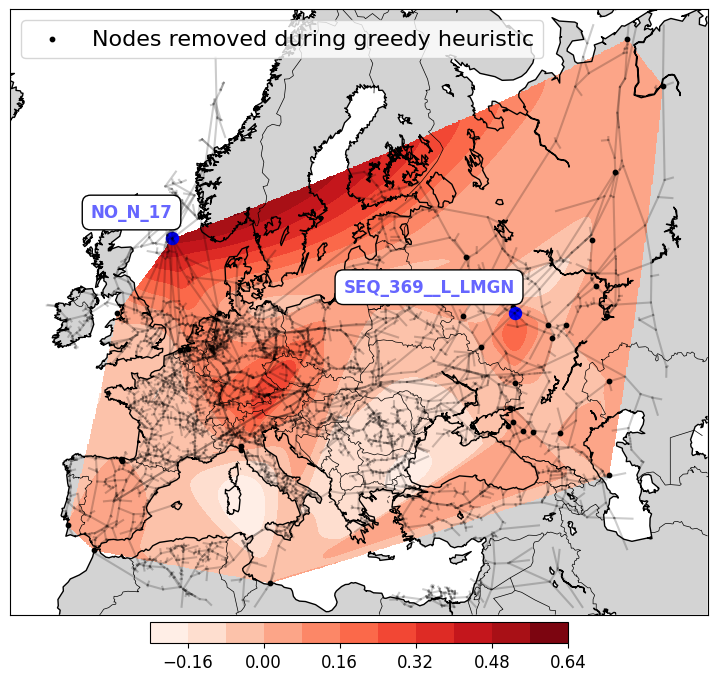

In [22]:
metric = 'capacity_robustness_max_flow'
if analysis == 'centrality':
    metric = 'NPI'

df = node_removals_df.copy()
df[metric+'_diff'] = df[metric].diff().abs()

# Get the latitude and longitude of nodes present in the DataFrame
df = df.iloc[1:]

nodes_in_df = df['removed_entity'].values
lats = [G_simple_directed.nodes[node]['lat'] for node in nodes_in_df if node in G_simple_directed.nodes()]
lons = [G_simple_directed.nodes[node]['long'] for node in nodes_in_df if node in G_simple_directed.nodes()]

# Create a grid for interpolation
lon_min, lon_max = min(lons), max(lons)
lat_min, lat_max = min(lats), max(lats)
num_points = 500
lons_interp = np.linspace(lon_min, lon_max, num_points)
lats_interp = np.linspace(lat_min, lat_max, num_points)
lons_mesh, lats_mesh = np.meshgrid(lons_interp, lats_interp)

# Convert the latitude and longitude of nodes in the DataFrame to numpy array
points = np.array(list(zip(lons, lats)))

# Remove NaN values from the values array
values = df[metric+'_diff'].values
mask = ~np.isnan(values)
values = values[mask]
points = points[mask]

# Interpolate the metric values on the grid
metric_interp = griddata(points, values, (lons_mesh, lats_mesh), method='cubic')

plt.figure(figsize=(9, 10))

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the interpolated heatmap
x_interp, y_interp = m(lons_mesh, lats_mesh)
sc = m.contourf(x_interp, y_interp, metric_interp, cmap='Reds', levels=10)

# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', shrink=0.6, aspect=20, pad=0.01)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize=12)

# Plot the points themselves
x, y = m(lons, lats)
m.scatter(x, y, c='black', marker='o', s=10, label='Nodes removed during greedy heuristic')

# Highlight specific nodes if metric is 'capacity_robustness_max_flow'
if metric == 'capacity_robustness_max_flow':
    highlight_nodes = ['NO_N_17', 'SEQ_369__L_LMGN']
    highlight_lats = [G_simple_directed.nodes[node]['lat'] for node in highlight_nodes if node in G_simple_directed.nodes()]
    highlight_lons = [G_simple_directed.nodes[node]['long'] for node in highlight_nodes if node in G_simple_directed.nodes()]
    highlight_x, highlight_y = m(highlight_lons, highlight_lats)
    m.scatter(highlight_x, highlight_y, c='blue', marker='o', s=75)

    for i, node in enumerate(highlight_nodes):
        if node in G_simple_directed.nodes():
            plt.text(highlight_x[i], highlight_y[i]+250000, node, fontsize=12, fontweight='bold', ha='right', color='blue', alpha=0.6, bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"))

# Plot all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.2)

plt.legend(loc='upper left', fontsize=16)

plt.savefig('saved_plots/heatmaps/' + analysis + '/node_impact.png', bbox_inches='tight', pad_inches=0)

plt.show()


# EDGE: Flow Subgraph Map

In [40]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [41]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [42]:
# Analysis; 'centrality' or 'max_flow'
analysis = 'centrality'

In [43]:
metric = 'capacity_robustness_max_flow'
if analysis == 'centrality':
    metric = 'NPI'

edge_removals_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/wfcr_edge_removal_df.pkl')
if analysis == 'centrality':
    edge_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_edge_removal.pkl').head(100)

In [44]:
# Add a column 'diff' that shows the difference between the metric value of the current and previous row
edge_removals_df['diff'] = edge_removals_df[metric].diff().abs()


In [45]:
edge_removals_df

,iteration,removed_entity,NPI,connectedness,reach,connectivity,heuristic,diff
0,0.0,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN
1,1.0,"{LKD_N_148, LKD_N_158}",0.948296,0.991249,1.000000,0.956669,greedy,0.051704
2,2.0,"{SEQ_10405__S_LMGN, N_161_L_LMGN}",0.807236,0.988078,1.000000,0.816976,greedy,0.141061
3,3.0,"{N_730_M_LMGN, N_731_M_LMGN}",0.714520,0.973639,1.000000,0.733866,greedy,0.092716
4,4.0,"{SEQ_5193__L_LMGN, SEQ_5183__L_LMGN}",0.598821,0.964793,1.000000,0.620674,greedy,0.115699
...,...,...,...,...,...,...,...,...
95,95.0,"{SEQ_8173__M_LMGN, SEQ_8179__M_LMGN}",0.110477,0.851416,0.874195,0.148430,greedy,0.000744
96,96.0,"{SEQ_4441__L_LMGN, SEQ_4451__L_LMGN}",0.106048,0.851416,0.846181,0.147196,greedy,0.004429
97,97.0,"{N_822_S_LMGN, N_596_S_LMGN}",0.105117,0.850138,0.846181,0.146123,greedy,0.000931
98,98.0,"{LKD_N_521, SEQ_11702_p}",0.104429,0.849075,0.846181,0.145349,greedy,0.000687


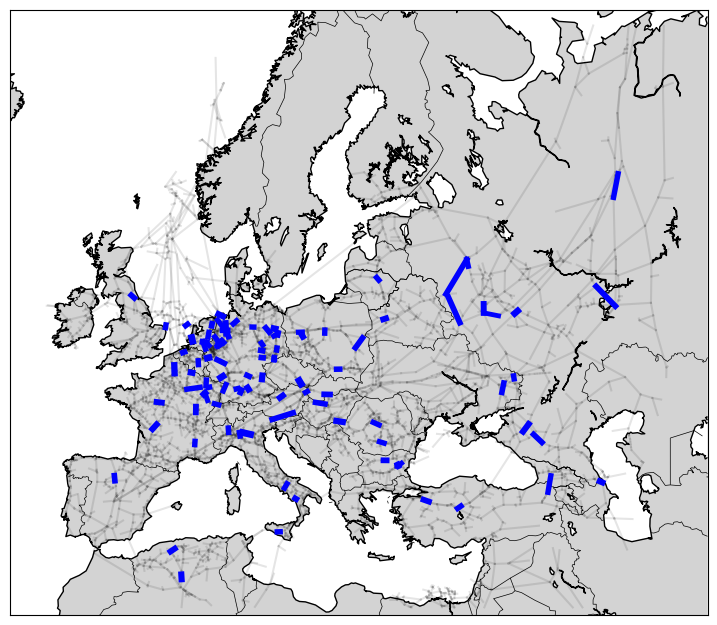

In [46]:
plt.figure(figsize=(9, 10))

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Get the maximum value of 'diff' for normalization
max_diff = edge_removals_df['diff'].max()

# Plot all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.1)

# Plot the points themselves
edge_removals_df = edge_removals_df.iloc[1:]
for edge, diff in zip(edge_removals_df['removed_entity'], edge_removals_df['diff']):
    edge = tuple(edge)
    u, v = edge
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    # Adjust linewidth based on the value of 'diff'
    linewidth = 5*(diff / max_diff)**(1/20)
    m.plot(x, y, 'b-', linewidth=linewidth)

#plt.savefig('saved_plots/heatmaps/'+analysis+'/edge_impact.png', bbox_inches='tight', pad_inches=0)

plt.show()
